# Premise
Or background.

Supervisory control theory is brought up early 80s'. 

# Import packages

In [78]:
import pandas as pd
import numpy as np
import os, sys
from matplotlib import pyplot as plt
from Utility.Hygraph_json import Hyper_Read
import hypernetx as hnx

In [79]:
# load hypergraph and nodes name data
# add current directory to path
sys.path.append(os.getcwd())

node_json_path = r'./handlingcase/'
# check if route exists
if not os.path.exists(node_json_path):
    print('nodes.json not found')
    sys.exit(1)
else:
    json_files = [file for file in os.listdir(node_json_path) if file.endswith('.json')]
    print("json files are:", json_files)

# check file names and assign to node and edge json
if "edge" in json_files[0]:
    edge_json = json_files[0]
    node_json = json_files[1]
else:
    edge_json = json_files[1]
    node_json = json_files[0]

edge_path = os.path.join(node_json_path, edge_json)
node_path = os.path.join(node_json_path, node_json)
print("edge path is:", edge_path)
print("node path is:", node_path)

json files are: ['Handling_hyperedges.json', 'Handling_nodes.json']
edge path is: ./handlingcase/Handling_hyperedges.json
node path is: ./handlingcase/Handling_nodes.json


### Convert json files into node, edge data frame

In [80]:
node = Hyper_Read(node_path).js2df()
edge = Hyper_Read(edge_path).js2df()

return hyperedges data


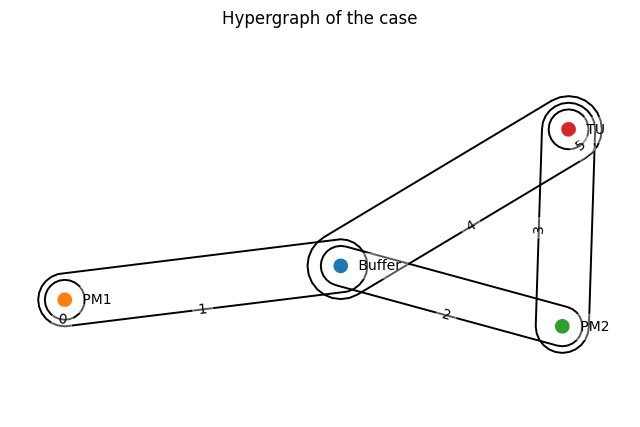

In [81]:
from Utility.data_func import Graph_conv
G1 = Graph_conv(edge, node)
graph1 = hnx.Hypergraph(G1)

from collections import defaultdict
# make a plot function
colors = defaultdict(lambda: plt.cm.tab10(len(colors)%10))
def get_node_color(v):
    return colors[v]
cmap = plt.cm.Blues
alpha = .2
sizes = np.array([graph1.size(e) for e in graph1.edges()])
norm = plt.Normalize(sizes.min(), sizes.max())

fig, axs = plt.subplots(1,1, figsize = (8, 5))
hnx.draw(graph1, 
        ax = axs,
         with_node_labels=True, 
         with_edge_labels=True, 
         node_labels_kwargs={
                'fontsize': 10
         },
         nodes_kwargs = {
             'color': get_node_color
         },
         edge_labels_kwargs = {
            'fontsize': 10,
         },
         edges_kwargs = {'linewidth':1.4,
                         'edgecolors': 'black',
        },
)
plt.title('Hypergraph of the case')
plt.show()

## Incidence matrix and adjacency matrix (Design structure matrix)

The current case (data in *handlingcase* folder) represents with relationships between components, the relationships which are established through requirements designed with engineers. <br/>

The relationships are also established when their transition rules are settled. The detail of how the case data is constructed can reference the ESCET documentation. <br/>


The source data is recorded with nodes, and edges. Their data form can be viewed as a hypergraph. A hypergraph is a special graph that allows multiple nodes on the same edge. <br/>

Hence, we can check its incidence matrix first.

The incidence matrix $H$ of a hypergraph with $|V|$ columns and $|E|$ rows, $H$, then can be expressed as:
$$
\begin{equation}
    H_{ij} =
\begin{cases}
1 & \text{if } v_i \in e_j \\
0 & \text{otherwise}.
\end{cases}
\end{equation}
$$
An adjacency matrix is a square matrix that represents the transition relationships in pairs of nodes, which are indexed by the vertices of $H$ with $\forall i, j \in V, i \neq j$, and the entry of the adjacency matrix is $a_{i,j} = |\{e \in E: i,j \in e\}|$, with $a_{i,i}=0$.

In [82]:
from Utility.Hypergraph_matrix import Hyper_matrix
w = np.ones(len(node)) # initial as unit array
H = Hyper_matrix(edge_path, node, edge, w, edge).IncidenceMatrix_H()
print("Incidence matrix is:\n", H)
mat, rindex = graph1.adjacency_matrix(s=1, index=True)
print("adjacency matrix is:\n", mat.todense())
print("Componenet index as: ",rindex)

Incidence matrix is:
 [[1 1 0 0 0 0]
 [0 0 1 1 0 0]
 [0 1 1 0 1 0]
 [0 0 0 1 1 1]]
adjacency matrix is:
 [[0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]]
Componenet index as:  [' Buffer' ' PM1' ' PM2' ' TU']


Currently, the popular variable reorder algorithms for deriving variables ordering reference the adjacency matrix, or design structure matrix, to derive the variable ordering sequence for supervisor synthesis. <br/>

For example, one can utilize the Sloan ordering algorithm to sort variable ordering sequence based on the given matrix.

### Sloan order method

“Each node in the queue has a priority which is determined so that a low current degree and a large distance from the end node ensures a high priority.” (Sloan, 1989, p. 2656) 

The node with the highest priority is chosen as the next node to be labelled and then deleted from the queue. 

“The queue is then updated using the <font color="#e36c09">connectivity information</font> for the graph and the whole process is repeated until all the nodes have been labelled.” (Sloan, 1989, p. 2656)

Overall, it places non-zero elements near the diagonal to result in a lower profile of the matrix.

#### A case for Sloan ordering

Load case: Bridge


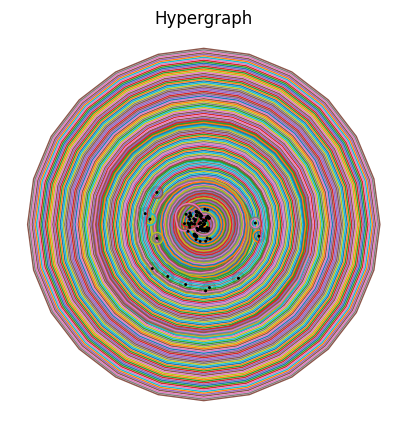

In [83]:
from Utility.Hyper_read import *
from Utility.Hypergraph_matrix import Hyper_matrix
from Utility.Clustering import *
from Utility.sloan import *
file_read = r'./data/'
files = os.listdir(file_read)
data = [file for file in files if file.endswith('data.json')]
file_dir_ = os.path.join(file_read, data[0])

Graph = Hyper_Read(file_dir_).df_2_Hypergraph() # whole graph
Title = Read_graph(file_dir_).return_graph_title()
print(f"Load case: {Title}")

nodes = Hyper_Read(file_dir_).js2df()[0]
edges = Hyper_Read(file_dir_).js2df()[1]
# make the edges into the graph
Graph = {}
for key in edges:
    Graph[key] = edges[key]['nodes']
H = hnx.Hypergraph(Graph)
Graph = H
# %matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title('Hypergraph')
hnx.draw(Graph, ax=ax, with_edge_counts=False, with_node_counts=False, with_node_labels=False, with_edge_labels=False)


In [84]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
adj_original = Hyper_matrix(file_dir_, nodes, edges, w=None).AdjacencyMatrix_A().astype(np.float64)
degree = Hyper_matrix(file_dir_, nodes, edges, w=None).Deg_Vertex(diag=False)
Lapalacian = Hyper_matrix(file_dir_, nodes, edges, w=None).LaplacianMatrix_L().astype(np.float64)
name_label = 'cluster_label'
Spectral_clusterer = SpectralClustering(assign_labels="discretize",random_state=0, eigen_solver='arpack', n_clusters=5)
Spectral_result = Spectral_clusterer.fit(adj_original)
Spectral_Ap = ClusterToFile(nodes=nodes,edges=edges, clusters_label=Spectral_result.labels_, savefile=False, name = name_label, Adj= adj_original, D_V=degree)
clusterer = AffinityPropagation(affinity='precomputed')
Spectral_Ap

/Users/wulynch/opt/anaconda3/envs/BDD/lib/python3.8/site-packages/sklearn/cluster/_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/wulynch/opt/anaconda3/envs/BDD/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,label,cluster_label,id,Adj,Degree
0,BB.Alternate,0,0,0.0,0.0
77,VTL2.Actuator,0,77,0.0,41.0
76,VTL2.Activated,0,76,0.0,2.0
73,VTL1.Red2,0,73,0.0,0.0
72,VTL1.Red,0,72,0.0,1206.0
...,...,...,...,...,...
82,VTL2.Red2StaysOff,2,82,0.0,54.0
39,BR.Sensor,3,39,0.0,132.0
109,VTL6.Actuator,3,109,0.0,41.0
101,VTL5.Actuator,3,101,0.0,41.0


In [85]:
from Utility.Sort_clustering import *
PPnodes_spec = []
for i in range(Spectral_Ap.cluster_label.max()+1):
    if any(Spectral_Ap[Spectral_Ap[name_label]==i].count() == 0):
        print(f"cluster {i} is empty")
        continue
    Target_Sp = Spectral_Ap[Spectral_Ap[name_label]== i]
    # Target_clusters_table(Target_Sp, i)
    PPnodes_spec.append(Subgraph_PPnode(file_directory=file_dir_, cluster=Target_Sp, E= edges, Graph= Graph))

print("PPnodes_spec is:", PPnodes_spec)
SP = order4DS(data = Spectral_Ap, r=PPnodes_spec, name_C=name_label).DS_sorting4clusters(Spectral_Ap)
SP

/Users/wulynch/Documents/Project2/HyperNetX/hypernetx/classes/entity.py:1392: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties[self._misc_props_col] = self.properties[
/Users/wulynch/Documents/Project2/HyperNetX/hypernetx/classes/entity.py:1392: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties[self._misc_props_col] = self.properties[
/Users/wulynch/Documents/Project2/HyperNetX/hypernetx/classes/entity.py:1392: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties[self._misc_props_col] = self.properties[


PPnodes_spec is: [0, 0, 0, 0]


,label,cluster_label,id,Adj,Degree
0,BB.Alternate,0,0,0.0,0.0
1,VTL8.Red2,0,129,0.0,0.0
2,VTL7.Red2,0,121,0.0,0.0
3,VTL6.Red2,0,113,0.0,0.0
4,VTL5.Red2,0,105,0.0,0.0
...,...,...,...,...,...
127,BridgeCommands,2,40,0.0,1429.0
128,VTL6.Actuator,3,109,0.0,41.0
129,VTL5.Actuator,3,101,0.0,41.0
130,BR.Sensor,3,39,0.0,132.0


In [86]:
# Graph = Hyper_Read(file_dir_).df_2_Hypergraph() # whole graph
# list(Graph.nodes)

In [87]:
from Utility.sloan import *
data = Spectral_Ap
Cluster_lst = data[name_label].unique()
# Create an empty dataframe to save result 
df = pd.DataFrame()

for i in Cluster_lst:    
    check_data = data[data[name_label]==i]
    constrain_node = check_data['label'].tolist()
    if len(check_data) > 0 :
        if len(check_data) == 1 :
            print(f"Single component in cluster no {i}")
            df = pd.concat([df, check_data], ignore_index=True)
        else:
            Intersect_set = list(set(list(Graph.nodes)) & set(constrain_node))
            if len(Intersect_set) == 0:
                print(constrain_node)
                continue
            if len(Intersect_set) > 1:
                Graph.restrict_to_nodes(constrain_node)
                print(constrain_node)
            if Graph.restrict_to_nodes(constrain_node).is_connected() is not True:
                # reshapae to label, id and name_label
                check_data = check_data[['label', 'id', name_label]]
                df = pd.concat([df, check_data], ignore_index=True)
                print(f"Cluster no. {i} is not connected.")
                continue
            # re-ordering for the current cluster i
            SL_result = sloan_orderer4C(Graph.restrict_to_nodes(constrain_node), check_data)
            SL_result[name_label] = check_data[name_label].unique()[0]
            df = pd.concat([df, SL_result], ignore_index=True)
                
    else:
        print(f"Cluster no. {i} is empty.")

df

['BB.Alternate', 'VTL2.Actuator', 'VTL2.Activated', 'VTL1.Red2', 'VTL1.Red', 'VTL1.Green', 'VTL1.Actuator', 'VTL1.Activated', 'StopSigns.S5StaysOff', 'StopSigns.S5', 'VTL2.Red2', 'StopSigns.S3StaysOff', 'StopSigns.S2StaysOff', 'StopSigns.S2', 'StopSigns.S1StaysOff', 'StopSigns.Actuator', 'LMUnlockedTimer3', 'LMUnlockedTimer100', 'LMLockedTimer', 'LM.Valve', 'LM.Unlocked', 'StopSigns.S3', 'VTL2.RedStaysOff', 'VTL3.Activated', 'VTL3.Green', 'VTL8.Red2', 'VTL8.Red', 'VTL8.Activated', 'VTL7.RedStaysOff', 'VTL7.Red2', 'VTL7.Red', 'VTL7.Green', 'VTL7.Activated', 'VTL6.Red2', 'VTL6.Red', 'VTL6.Activated', 'VTL5.RedStaysOff', 'VTL5.Red2', 'VTL5.Green', 'VTL5.Activated', 'VTL4.Red2', 'VTL4.Red', 'VTL4.Activated', 'VTL3.RedStaysOff', 'VTL3.Red2', 'VTL3.Red', 'LM.UndesiredUnlock', 'LM.Stuck', 'StopSigns.S4StaysOff', 'LM.Locked', 'BD.Motor', 'BB1.UndesiredClosed', 'BB2.Open', 'BD.Closed', 'BB1.UndesiredOpen', 'BB1ClosedTimer', 'BB1OpenTimer', 'BD.NotDecelerating', 'BB2.Actuator', 'BB2OpenTimer', '

""


In [89]:
df

,label,cluster_label,id,Adj,Degree
0,BB.Alternate,0,0,0.0,0.0
1,VTL2.Actuator,0,77,0.0,41.0
2,VTL2.Activated,0,76,0.0,2.0
3,VTL1.Red2,0,73,0.0,0.0
4,VTL1.Red,0,72,0.0,1206.0
...,...,...,...,...,...
127,VTL2.Red2StaysOff,2,82,0.0,54.0
128,BR.Sensor,3,39,0.0,132.0
129,VTL6.Actuator,3,109,0.0,41.0
130,VTL5.Actuator,3,101,0.0,41.0
